### **Importing neccesary libraries and Downloading the dataset**

In [1]:
import torch
from matplotlib import pyplot as plt
import numpy as np
import cv2
import os
import random
from IPython.display import Image
from PIL import Image, ImageDraw
import shutil
import sklearn as sk
from sklearn.model_selection import train_test_split

In [ ]:
!git clone https://github.com/ultralytics/yolov5

In [2]:
%cd yolov5

C:\Users\aseem\Downloads\Calorie\yolov5


In [ ]:
!pip install -r requirements.txt 

In [5]:
%cd ..

C:\Users\aseem\Downloads\Calorie


In [ ]:
!git clone https://github.com/Liang-yc/ECUSTFD-resized-

In [ ]:
path = 'ECUSTFD-resized-\JPEGImages'
arr = os.listdir(path)
print(len(arr))
print(arr)

### **Loading and Testing the Model**

In [9]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to C:\Users\aseem/.cache\torch\hub\master.zip
YOLOv5  2022-6-14 Python-3.9.7 torch-1.10.0 CUDA:0 (NVIDIA GeForce RTX 3070 Laptop GPU, 8192MiB)



  0%|          | 0.00/14.1M [00:00<?, ?B/s]


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [ ]:
model

In [11]:
img = 'ECUSTFD-resized-/JPEGImages/banana013T(1).JPG'

results = model(img)
results.print()

image 1/1: 612x816 1 banana
Speed: 36.0ms pre-process, 3078.0ms inference, 49.0ms NMS per image at shape (1, 3, 480, 640)


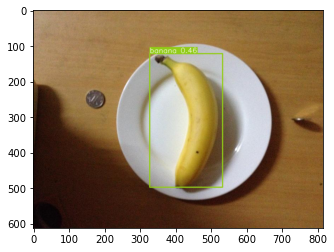

In [12]:
%matplotlib inline 
plt.imshow(np.squeeze(results.render()))
plt.show()

### **Making the YOLO Dataset**

In [15]:
class_name_to_id_mapping = {"coin": 0,
                            "mango": 1,
                            "apple": 2,
                            "plum": 3,
                            "litchi": 4,
                            "sachima": 5,
                            "orange": 6,
                            "peach": 7,
                            "lemon": 8,
                            "pear": 9,
                            "qiwi": 10,
                            "bread": 11,
                            "egg": 12,
                            "doughnut": 13,
                            "banana": 14,
                            "fired_dough_twist": 15,
                            "tomato": 16,
                            "mooncake": 17,
                            "bun": 18,
                            "grape": 19,
                            "mix":20}

In [13]:
import xml.etree.ElementTree as ET 
from tqdm import tqdm

def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()
    
    # Initialise the info dict 
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name 
        if elem.tag == "filename":
            info_dict['filename'] = elem.text
            
        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))
            
            info_dict['image_size'] = tuple(image_size)
        
        # Get details of the bounding box 
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text
                    
                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)            
            info_dict['bboxes'].append(bbox)
    
    return info_dict

In [19]:
def convert_to_yolov5(info_dict):
    print_buffer = []
    
    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
        
        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2 
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])
        
        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]  
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
        
    # Name of the file which we have to save 
    save_file_name = os.path.join("annotations", info_dict["filename"].replace("JPG", "txt"))
    
    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))

In [20]:
# Get the annotations
annotations = [os.path.join('Annotations', x) for x in os.listdir('Annotations') if x[-3:] == "xml"]
annotations.sort()

# Convert and save the annotations
for ann in tqdm(annotations):
    info_dict = extract_info_from_xml(ann)
    convert_to_yolov5(info_dict)
annotations = [os.path.join('Annotations', x) for x in os.listdir('Annotations') if x[-3:] == "txt"]

100%|█████████████████████████████████████████████████████████████████████████████| 2978/2978 [00:09<00:00, 308.42it/s]


In [ ]:
random.seed(321)

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))
#print(class_id_to_name_mapping)

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file 
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("Annotations", "JPEGImages").replace("txt", "JPG")
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

In [ ]:
# Read images and annotations
images = [os.path.join('images', x) for x in os.listdir('images')]
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "txt"]

images.sort()
annotations.sort()

# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

In [32]:
print(len(train_images))
print(len(train_annotations))
print(len(val_images))
print(len(val_annotations))
print(len(test_images))
print(len(test_annotations))

2382
2382
298
298
298
298


In [33]:
#Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
move_files_to_folder(train_images, 'JPEGImages/train')
move_files_to_folder(val_images, 'JPEGImages/val/')
move_files_to_folder(test_images, 'JPEGImages/test/')
move_files_to_folder(train_annotations, 'annotations/train/')
move_files_to_folder(val_annotations, 'annotations/val/')
move_files_to_folder(test_annotations, 'annotations/test/')

### **Training the model on the custom made dataset**

In [9]:
%cd yolov5

C:\Users\aseem\Downloads\Calorie\yolov5


In [2]:
torch.cuda.is_available()

True

In [3]:
torch.cuda.device_count()

1

In [4]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3070 Laptop GPU'

In [ ]:
!python train.py --img 320 --batch 16 --epochs 50 --data data/data.yaml --weights yolov5s.pt --workers 2 --device 0 

### **Testing the model**

In [2]:
%cd yolov5

C:\Users\aseem\Downloads\Calorie\yolov5


In [3]:
model = torch.hub.load('ultralytics/yolov5', 'custom', path='runs/train/exp4/weights/best.pt', force_reload=True)

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to C:\Users\aseem/.cache\torch\hub\master.zip
YOLOv5  2023-1-26 Python-3.9.7 torch-1.10.0 CUDA:0 (NVIDIA GeForce RTX 3070 Laptop GPU, 8192MiB)

Fusing layers... 
Model summary: 213 layers, 7064065 parameters, 0 gradients
Adding AutoShape... 


In [6]:
img = 'images/val/pear001T(7).JPG'
results = model(img)
results.print()

image 1/1: 612x816 1 coin, 1 pear
Speed: 34.0ms pre-process, 2722.6ms inference, 35.9ms NMS per image at shape (1, 3, 480, 640)


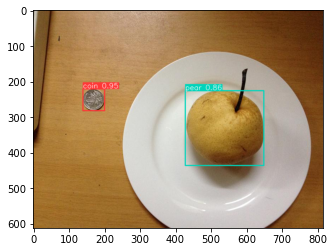

In [7]:
%matplotlib inline 
plt.imshow(np.squeeze(results.render()))
plt.show()

In [8]:
results.xywh

[tensor([[170.91644, 251.97488,  61.79820,  61.51746,   0.95410,   0.00000],
         [539.10236, 331.14191, 220.45215, 209.94153,   0.86170,   9.00000]], device='cuda:0')]

### **Calculating Calories**

In [9]:
def get_prediction(top_image,side_image):
    top_results = model(top_image)
    side_results = model(side_image)
    
    fig = plt.figure(figsize=(20, 20))
    rows = 1
    columns = 2
                                            
    fig.add_subplot(rows, columns, 1)
    plt.imshow(np.squeeze(top_results.render()))
    plt.axis('off')
    plt.title("Top Image")
    
    fig.add_subplot(rows, columns, 2)
    plt.imshow(np.squeeze(side_results.render()))
    plt.axis('off')
    plt.title("Side Image")
    
    return top_results, side_results

In [191]:
class_map = ["coin", "mango", "apple", "plum", "litchi", "sachima", "orange", "peach", "lemon", "pear", "qiwi",
                 "bread", "egg", "doughnut", "banana", "fired_dough_twist", "tomato", "mooncake", "bun", "grape", "mix"]
    
error_map = [np.nan, 0.5233, 0.5233, 0.5233, 0.5233, 1.000, 0.5233, 0.5233, 0.5233, 0.5233, 0.5233,
             1.000, 0.5233, 0.697, np.nan, np.nan, 0.5233, 0.785, np.nan, np.nan, np.nan]

error_map_regression = [np.nan, 0.5233, 0.5233, 0.5233, 0.5233, 1.000, 0.5233, 0.5233, 0.5233, 0.5233, 0.5233,
                        1.000, 0.5233, 0.697, 0.305, 0.358, 0.5233, 0.785, 0.501, 0.152, np.nan]

density_map_dataset = [np.nan, 1.105, 0.787, 1.005, 0.996, 0.217, 0.954, 1.021, 0.960, 0.951, 0.982,
                 0.185, 1.161, 0.309, 0.922, 0.630, 0.988, 1.043, 0.343, 0.955, np.nan]
    
density_map_google = [np.nan, 0.700, 0.960, 1.042, 0.800, np.nan, 0.814, 1.24, 0.912, np.nan, 0.990,
                 0.220, 1.033, 0.310, 1.07, np.nan, 1.026, np.nan, np.nan, np.nan, np.nan]

calorie_map = [np.nan, 0.600, 0.520, 0.460, 0.660, 5.070, 0.470, 0.390, 0.290, 0.580, 0.610,
                 2.650, 1.550, 4.120, 0.890, 3.730, 0.180, 4.540, 2.560, 0.670, np.nan]

In [201]:
def get_calories(top_preds, side_preds, actual_coin_size=25):
    top = top_preds.xywh[0]
    side = side_preds.xywh[0]
    
    col_index_to_sort = 5
    top_sorted_indices = top[:, col_index_to_sort].sort()[1]
    top = top[top_sorted_indices]
    side_sorted_indices = side[:, col_index_to_sort].sort()[1]
    side = side[side_sorted_indices]
    
    coin_top_edge = (top[0][2] + top[0][3])/2
    coin_side_edge = (side[0][2] + side[0][3])/2
    print('Size of coin w/o scaling from the the top view: ', round(coin_top_edge.item(), 3), 'mm')
    print('Size of coin w/o scaling from the the side view: ', round(coin_side_edge.item(), 3), 'mm')
    print("")
    
    top_scale_factor = actual_coin_size/coin_top_edge
    side_scale_factor = actual_coin_size/coin_side_edge
    print('Top Scaling Factor:', round(top_scale_factor.item(), 3))
    print('Side Scaling Factor:', round(side_scale_factor.item(), 3))
    print("")
    
    for i in range(1, len(top)):
        object_top_length = top_scale_factor * top[i][2]
        object_top_breadth = top_scale_factor * top[i][3]
        object_side_height = side_scale_factor * side[i][3]
        #object_side_length = side_scale_factor * side[i][2]
        
        volume = object_top_length * object_top_breadth * object_side_height
        error_percentage = error_map_regression[int(top[i][5].item())]
        actual_volume = volume *  error_percentage
        
        density = density_map_dataset[int(top[i][5].item())]
        mass = (actual_volume/1000) * density
        
        calorie_per_gm = calorie_map[int(top[i][5].item())]
        final_calories = mass * calorie_per_gm
        
        print('Object:', class_map[int(top[i][5].item())])
        print("Lenght: ", round(object_top_length.item(), 3), 'mm')
        print("Breadth: ", round(object_top_breadth.item(), 3), 'mm')
        print("Height: ", round(object_side_height.item(), 3), 'mm')
        print("Volume of Bounding Cuboid:", round((volume/1000).item(), 3), 'cm3')
        print('Volume occupied in the Cuboid (Error):', error_map_regression[int(top[i][5].item())], '%')
        print("Actual volume: ", round((actual_volume/1000).item(), 3), 'cm3')
        print("Mass: ", round(mass.item(), 3), 'g')
        print("Calories: ", round(final_calories.item(), 3), 'cal')
        print("")
        #print("LENGTH = BREADTH: ", round(object_side_length.item(), 3))
    

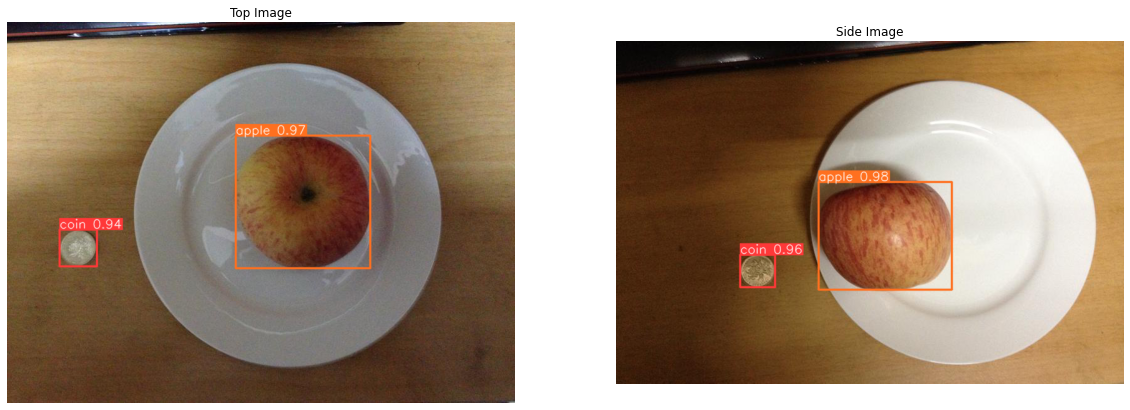

In [193]:
top, side = get_prediction("images1/apple001T(1).JPG", "images1/apple001S(1).JPG")

In [194]:
get_calories(top, side)

Size of coin w/o scaling from the the top view:  59.354 mm
Size of coin w/o scaling from the the side view:  53.76 mm

Top Scaling Factor: 0.421
Side Scaling Factor: 0.465

Object: apple
Lenght:  91.213 mm
Breadth:  89.68 mm
Height:  80.882 mm
Volume of Bounding Cuboid: 661.613 cm3
Volume occupied in the Cuboid (Error): 0.5233 %
Actual volume:  346.222 cm3
Mass:  272.477 g
Calories:  141.688 cal



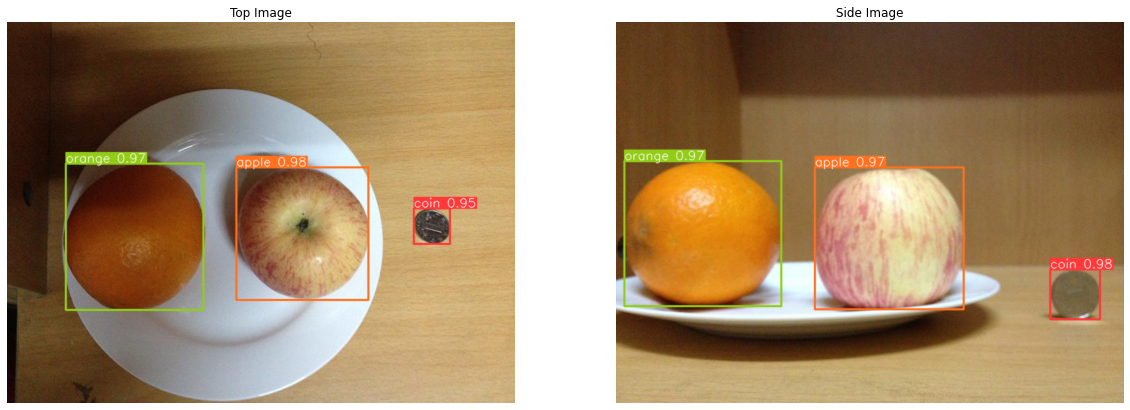

In [195]:
top, side = get_prediction("images1/mix001T(2).JPG", "images1/mix001S(2).JPG")

In [196]:
get_calories(top, side)

Size of coin w/o scaling from the the top view:  57.998 mm
Size of coin w/o scaling from the the side view:  79.979 mm

Top Scaling Factor: 0.431
Side Scaling Factor: 0.313

Object: apple
Lenght:  91.304 mm
Breadth:  91.807 mm
Height:  71.483 mm
Volume of Bounding Cuboid: 599.2 cm3
Volume occupied in the Cuboid (Error): 0.5233 %
Actual volume:  313.562 cm3
Mass:  246.773 g
Calories:  128.322 cal

Object: orange
Lenght:  95.426 mm
Breadth:  101.314 mm
Height:  72.71 mm
Volume of Bounding Cuboid: 702.962 cm3
Volume occupied in the Cuboid (Error): 0.5233 %
Actual volume:  367.86 cm3
Mass:  350.938 g
Calories:  164.941 cal



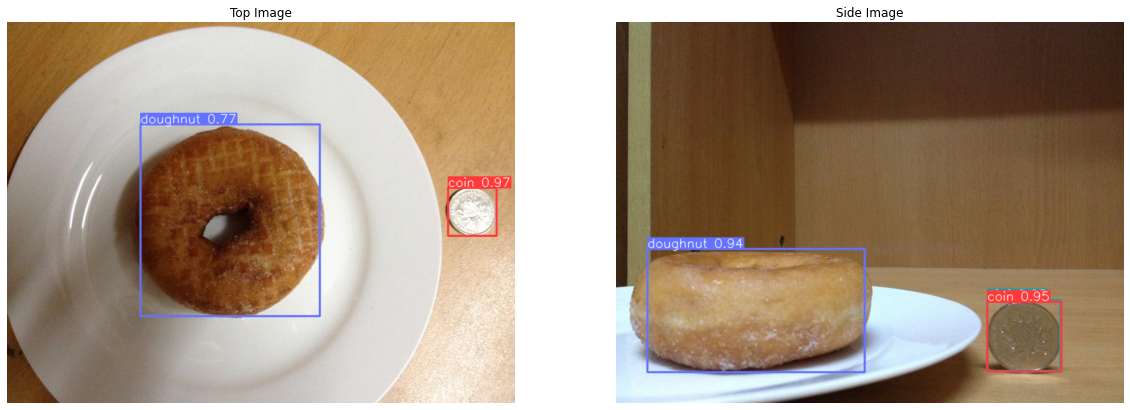

In [197]:
top, side = get_prediction("images1/doughnut001T(2).JPG", "images1/doughnut001S(2).JPG")

In [198]:
get_calories(top, side)

Size of coin w/o scaling from the the top view:  77.451 mm
Size of coin w/o scaling from the the side view:  115.715 mm

Top Scaling Factor: 0.323
Side Scaling Factor: 0.216

Object: doughnut
Lenght:  92.731 mm
Breadth:  99.477 mm
Height:  24.544 mm
Volume of Bounding Cuboid: 226.412 cm3
Volume occupied in the Cuboid (Error): 0.697 %
Actual volume:  157.809 cm3
Mass:  48.763 g
Calories:  200.904 cal



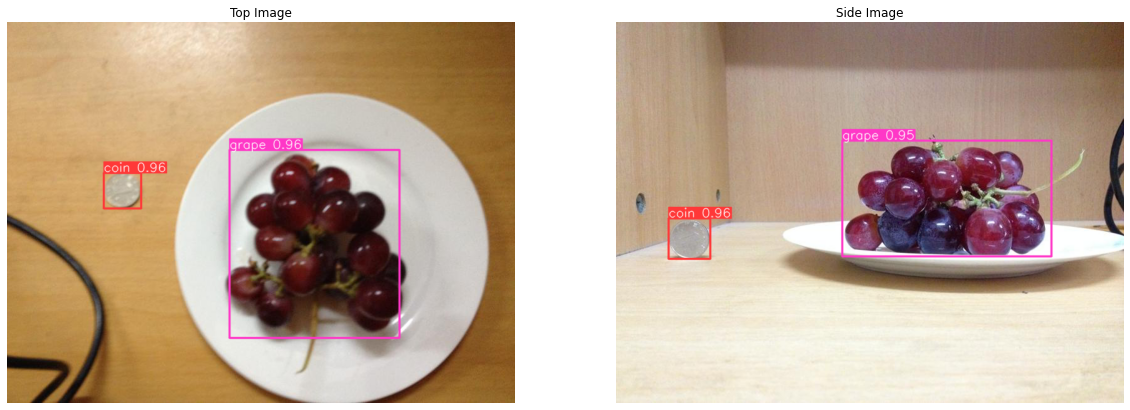

In [199]:
top, side = get_prediction("images1/grape002T(9).JPG", "images1/grape002S(9).JPG")

In [202]:
get_calories(top, side)

Size of coin w/o scaling from the the top view:  58.616 mm
Size of coin w/o scaling from the the side view:  65.502 mm

Top Scaling Factor: 0.427
Side Scaling Factor: 0.382

Object: grape
Lenght:  116.514 mm
Breadth:  128.834 mm
Height:  71.031 mm
Volume of Bounding Cuboid: 1066.246 cm3
Volume occupied in the Cuboid (Error): 0.152 %
Actual volume:  162.069 cm3
Mass:  154.776 g
Calories:  103.7 cal



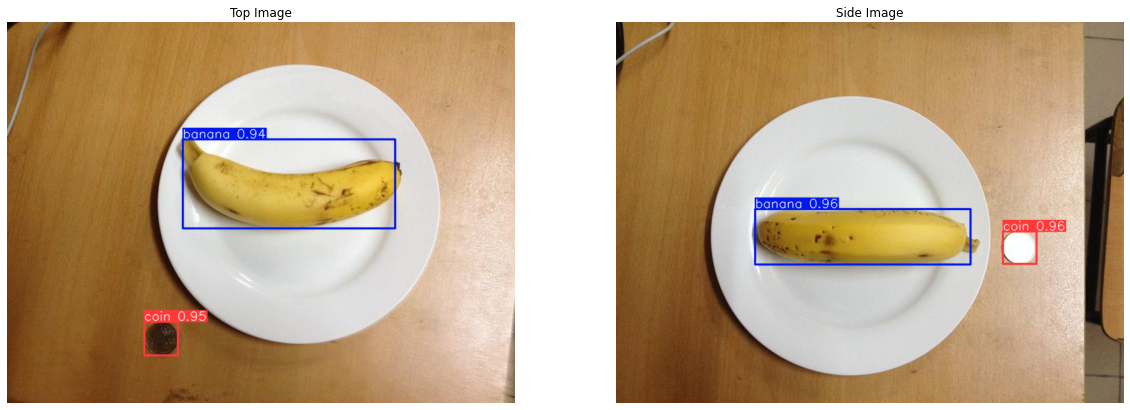

In [203]:
top, side = get_prediction("images1/banana001T(1).JPG", "images1/banana001S(1).JPG")

In [204]:
get_calories(top, side)

Size of coin w/o scaling from the the top view:  54.183 mm
Size of coin w/o scaling from the the side view:  53.147 mm

Top Scaling Factor: 0.461
Side Scaling Factor: 0.47

Object: banana
Lenght:  157.61 mm
Breadth:  66.051 mm
Height:  41.892 mm
Volume of Bounding Cuboid: 436.106 cm3
Volume occupied in the Cuboid (Error): 0.305 %
Actual volume:  133.012 cm3
Mass:  122.637 g
Calories:  109.147 cal

